# Import, resize and save image files as .csv

This notebook does the following:

1. Obtains all filename and file paths of files ending with .jpg
2. Extracts label of the image: whether it is pathological or healthy from the file name
3. Saves file names, paths and labels into a .csv

4. Reading and saving images: 
    * Reads images one at a time, 
    * resizes them to be smaller, 
    * converts them to numpy arrays
    * unravels them to be a single vector
    * appends the vectors to a dataframe along with metadata about file and label, and 
    * saves a .csv of this clean dataset 

**Library Imports**

In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path

In [2]:
# get file paths for importing data
file_paths = glob.glob('../data/Images/*.jpg')

get file names and labels: pathological images have file names with `_g_` in them. Images of healthy retinas do not. For instance: 
* `Im001_ACRIMA.jpg` : healthy retina
* `Im696_g_ACRIMA.jpg`: retina with glaucoma


In [3]:
file_name = [Path(directory).name for directory in file_paths]

In [4]:
# get labels
label = [1 if '_g_' in name else 0 for name in file_name]

In [5]:
# create a dataframe and save to .csv for future use
files = pd.DataFrame({'file_path' : file_paths,
                      'file_name': file_name,
                      'label' : label})

# uncomment to save file to csv
# files.to_csv('../data/file_names.csv', index=False) 

**Look at a sample of images from both classes**

In [105]:
glaucoma_images = files[files['label']==1]['file_path'].sample(5)
healthy_images = files[files['label']==0]['file_path'].sample(5)

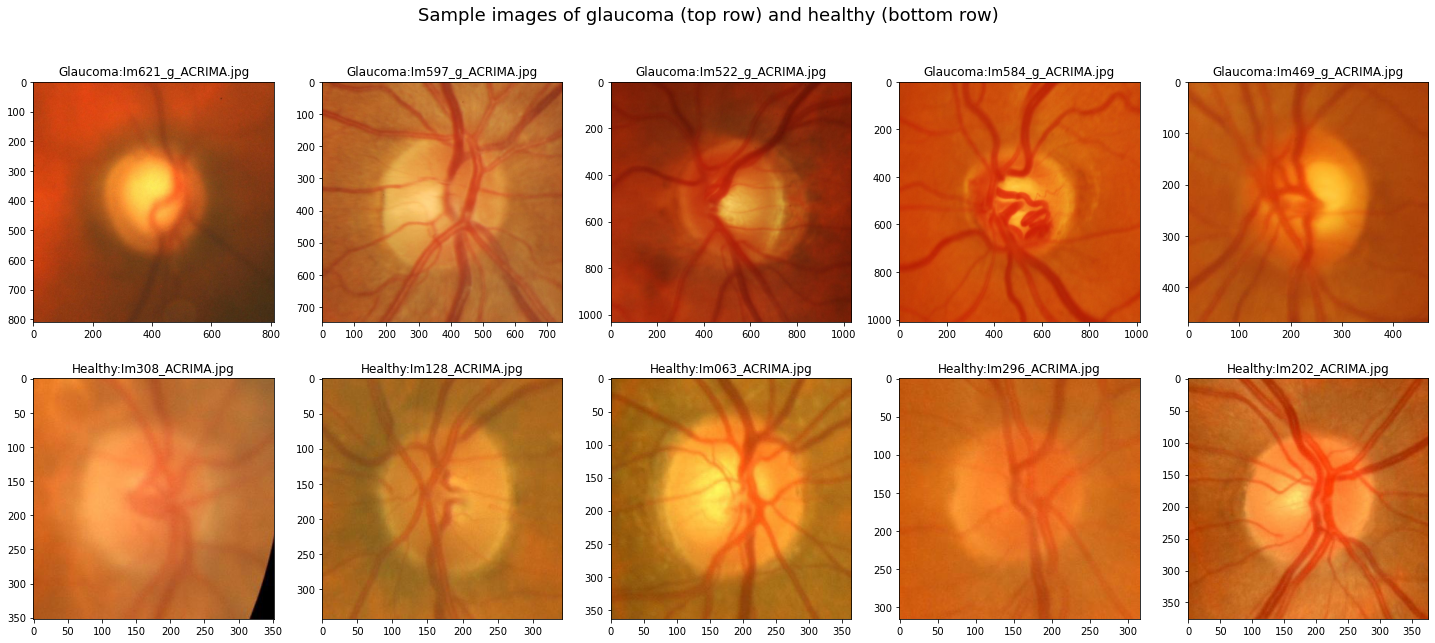

In [108]:
fig, ax = plt.subplots(2, 5, figsize=(25,10))
fig.suptitle('Sample images of glaucoma (top row) and healthy (bottom row)', size=18)

for i, f in enumerate(glaucoma_images):
    ax[0,i].imshow(Image.open(f))
    ax[0,i].set_title(f"Glaucoma:{Path(f).name}")

for i, f in enumerate(healthy_images):
    ax[1,i].imshow(Image.open(f))
    ax[1,i].set_title(f"Healthy:{Path(f).name}")

# uncomment below to save figure    
# plt.savefig('../figures/sample_images.png', bbox_inches='tight', dpi='figure')

**Plot distributions of pixel values for sets of sample images from both classes**

In [109]:
glaucoma_images = files[files['label']==1]['file_path'].sample(75)
healthy_images = files[files['label']==0]['file_path'].sample(75)
pixels_g = []
pixels_h = []
for i, f in enumerate(glaucoma_images):
    pixels_g = np.concatenate((pixels_g, np.asarray(Image.open(f).resize((178,178))).ravel()))

for i, f in enumerate(healthy_images):
    pixels_h = np.concatenate((pixels_h, np.asarray(Image.open(f).resize((178,178))).ravel()))

In [110]:
pixels_df = pd.DataFrame({'pixels':np.concatenate((pixels_g, pixels_h)),
                          'label':np.concatenate((['Glaucoma']*len(pixels_g),(['Healthy']*len(pixels_h))))})

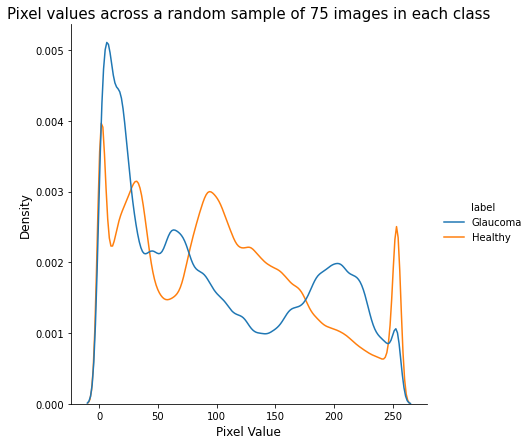

In [111]:
sns.displot(data=pixels_df, x='pixels', hue='label', kind='kde', height=6)
plt.xlabel('Pixel Value', size=12)
plt.ylabel('Density', size=12)
plt.title('Pixel values across a random sample of 75 images in each class', size=15);
# uncomment below to save figure    
# plt.savefig('../figures/pixel_distribution.png', bbox_inches='tight', dpi='figure')

**Import images and convert to numpy array**

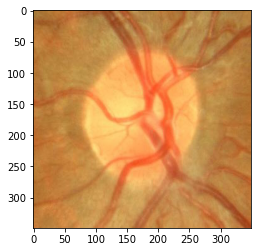

In [10]:
# check if numpy array can still be used as an image
x = np.asarray(Image.open(files['file_path'][0]))
plt.imshow(x)

In [11]:
# Check how to `.ravel()` and `.reshape()`
# unravel image tobe a vector
shape = x.shape
y = x.ravel()

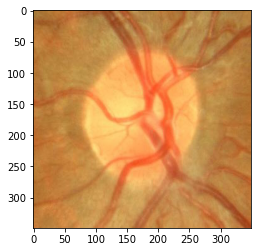

In [12]:
# reshape it back to the shape it was a plot it
plt.imshow(y.reshape(shape))

**Create dataframe with image array in it**

In [66]:
# Create a dataframe with fields: file path, file name, label, image and image shape

data_df = files.copy()
shape = []                                    # create an empty list to put shape of every image 
image = []                                    # crate empty list to store image

**All my images are of different sizes, so I will resize them to be the same size as the smallest image** 

In [67]:
# find the size of smallest image
im_size = []
for f in data_df['file_path']:
    im = Image.open(f)
    im_size.append(im.size)
min_size = min(im_size)

In [68]:
h = [h for h,w in im_size]
w = [w for h,w in im_size]

In [113]:
sizes_df = pd.DataFrame({'h':h, 'w':w})
sizes_df['label'] = files['label']
sizes_df['label'].replace({1:'glaucoma', 0:'healthy'}, inplace=True)
sizes_df.head()

,h,w,label
0,349,349,healthy
1,277,277,healthy
2,409,409,healthy
3,406,406,healthy
4,316,316,healthy


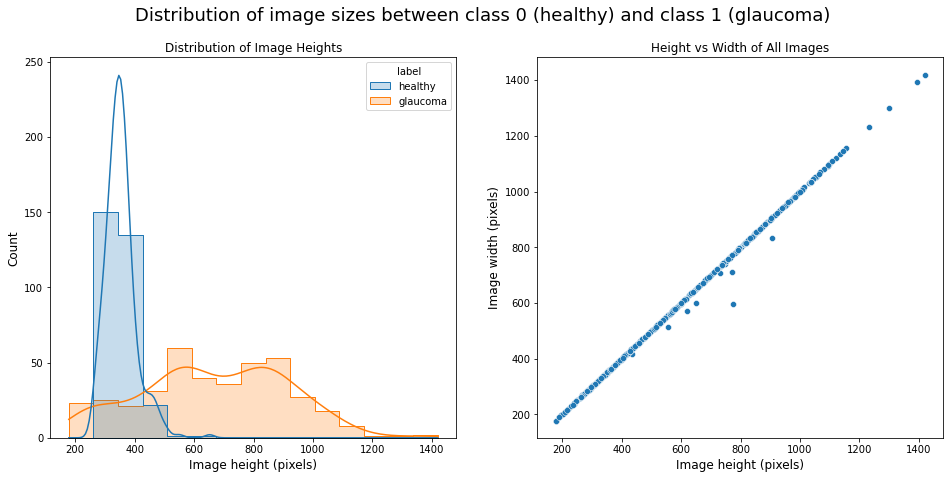

In [116]:
fig, ax = plt.subplots(1, 2, figsize=(16,7))
fig.suptitle('Distribution of image sizes between class 0 (healthy) and class 1 (glaucoma)', size=18)
sns.histplot(sizes_df, x='h', hue='label', kde=True, element='step', ax=ax[0])
ax[0].set_xlabel('Image height (pixels)', size=12)
ax[0].set_ylabel('Count', size=12)
ax[0].set_title('Distribution of Image Heights');

sns.scatterplot(data=sizes_df, x='h', y='w', ax=ax[1])
ax[1].set_xlabel('Image height (pixels)', size=12)
ax[1].set_ylabel('Image width (pixels)', size=12)
ax[1].set_title('Height vs Width of All Images');

# uncomment below to save figure    
# plt.savefig('../figures/size_distribution.png', bbox_inches='tight', dpi='figure')

In [18]:
min_size

(178, 178)

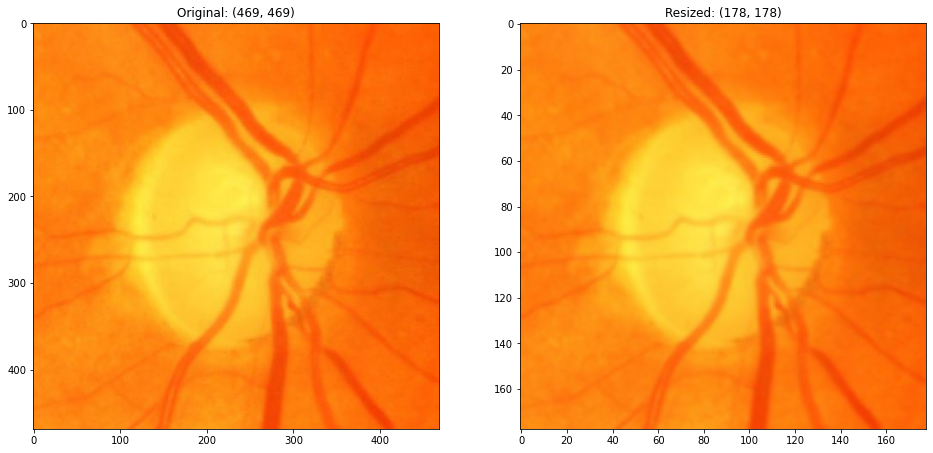

In [19]:
# double check to make sure that the resized image is not visibly reduced in quality
f = files['file_path'].sample(1).values[0]
im = Image.open(f)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(im)
ax[0].set_title(f'Original: {im.size}')

im = im.resize((178, 178))
ax[1].imshow(im)
ax[1].set_title(f'Resized: {im.size}');

    

**Create dataframe**

In [20]:
# for every image in the list:
for f in data_df['file_path']:
    im = Image.open(f)       # open image
    im = im.resize(min_size) # resize to size of smallest image
    im = np.asarray(im)      # convert to array
    shape.append(im.shape)   # save shape of array
    im = im.ravel()          # convert 3D array to a vector
    image.append(im)         # append to list

In [21]:
data_df['shape'] = shape
data_df

,file_path,file_name,label,shape
0,../data/Images\Im001_ACRIMA.jpg,Im001_ACRIMA.jpg,0,"(178, 178, 3)"
1,../data/Images\Im002_ACRIMA.jpg,Im002_ACRIMA.jpg,0,"(178, 178, 3)"
2,../data/Images\Im003_ACRIMA.jpg,Im003_ACRIMA.jpg,0,"(178, 178, 3)"
3,../data/Images\Im004_ACRIMA.jpg,Im004_ACRIMA.jpg,0,"(178, 178, 3)"
4,../data/Images\Im005_ACRIMA.jpg,Im005_ACRIMA.jpg,0,"(178, 178, 3)"
...,...,...,...,...
700,../data/Images\Im701_g_ACRIMA.jpg,Im701_g_ACRIMA.jpg,1,"(178, 178, 3)"
701,../data/Images\Im702_g_ACRIMA.JPG,Im702_g_ACRIMA.JPG,1,"(178, 178, 3)"
702,../data/Images\Im703_g_ACRIMA.JPG,Im703_g_ACRIMA.JPG,1,"(178, 178, 3)"
703,../data/Images\Im704_g_ACRIMA.jpg,Im704_g_ACRIMA.jpg,1,"(178, 178, 3)"


In [22]:
# convert the list of image arrays into a dataframe. This will place each pixel value in a separate column
# then concatenate it to the dataframe with the other details about the image
data_df = pd.concat([data_df, pd.DataFrame(image)], axis=1)
data_df.head()

,file_path,file_name,label,shape,0,1,2,3,4,5,...,95042,95043,95044,95045,95046,95047,95048,95049,95050,95051
0,../data/Images\Im001_ACRIMA.jpg,Im001_ACRIMA.jpg,0,"(178, 178, 3)",-94,115,50,-93,115,51,...,34,-89,72,34,-88,71,33,-93,67,28
1,../data/Images\Im002_ACRIMA.jpg,Im002_ACRIMA.jpg,0,"(178, 178, 3)",-112,108,56,-111,109,57,...,25,-111,75,26,-111,75,26,-110,76,27
2,../data/Images\Im003_ACRIMA.jpg,Im003_ACRIMA.jpg,0,"(178, 178, 3)",-2,-101,26,-2,-100,27,...,51,-36,-110,51,-36,-110,52,-37,-110,52
3,../data/Images\Im004_ACRIMA.jpg,Im004_ACRIMA.jpg,0,"(178, 178, 3)",-94,76,1,-94,79,1,...,1,-97,52,0,-97,54,0,-95,55,0
4,../data/Images\Im005_ACRIMA.jpg,Im005_ACRIMA.jpg,0,"(178, 178, 3)",-77,87,2,-77,87,2,...,11,-79,108,13,-78,109,14,-78,109,14


In [23]:
# uncomment to save dataframe to disk as .csv
# data_df.to_csv('../data/clean_data.csv', index=False)